In [1]:
import datacube
from dea_tools.datahandling import load_ard
import numpy as np
import geopandas as gpd
import xarray as xr
from odc.geo.geom import Geometry

from dea_tools.dask import create_local_dask_cluster
from dea_tools.spatial import xr_rasterize
from datacube.utils.masking import make_mask
from datacube.utils.cog import write_cog

In [2]:
dc = datacube.Datacube(app="LS_seasonalmax_waterextent")

In [13]:
client = create_local_dask_cluster(spare_mem='0.25Gb', display_client=True, return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/andres.sutton@student.unsw.edu.au/proxy/8787/status,
Dashboard: /user/andres.sutton@student.unsw.edu.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 14.77 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35595,Workers: 1
Dashboard: /user/andres.sutton@student.unsw.edu.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 14.77 GiB
Comm: tcp://127.0.0.1:44881,Total threads: 2
Dashboard: /user/andres.sutton@student.unsw.edu.au/proxy/34351/status,Memory: 14.77 GiB
Nanny: tcp://127.0.0.1:32793,


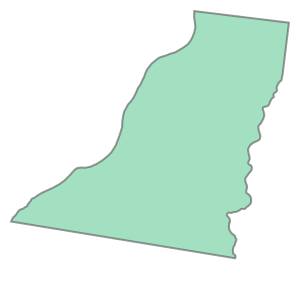

In [15]:
vector_file = 'lower_balonne_split.shp' #The vector file you uploaded to your Sandbox

polygon_to_drill = gpd.read_file(vector_file)

# Select polygon
shapely_geometry = polygon_to_drill.iloc[1].geometry

# Convert to Geometry object with CRS information
geom = Geometry(geom=shapely_geometry, crs=polygon_to_drill.crs)

geom

In [16]:
## Create a query object
query = {
    "geopolygon": geom,
    "resolution": (-30, 30),
    "dask_chunks": {"time": -1, "x": 500, "y": 500},
    "output_crs": "EPSG:3577",
}


In [ ]:
##Loop through years and calculate maximum water extent

for y in range(1991, 2025):
    # load Landsat data
    ds = load_ard(
    dc=dc,
    products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3', 'ga_ls9c_ard_3'],
    measurements=['nbart_red', 'nbart_green', 'nbart_nir',
                     'nbart_swir_1', 'nbart_swir_2', 'oa_fmask'
                  ],
    time = (f"{y}-{'07'}-{'01'}",f"{y+1}-{'06'}-{'30'}"),
    group_by="solar_day",
    **query)
    
    mask = xr_rasterize(polygon_to_drill, ds)

    # Mask dataset to set pixels outside the polygon to `NaN`
    ds_masked = ds.where(mask)

    #create and apply cloud/cloud shadow mask filter    
    cloud_free_mask = (
    make_mask(ds.oa_fmask, fmask="valid") |
    make_mask(ds.oa_fmask, fmask="water"))
    
    ds_masked = ds_masked.where(cloud_free_mask)

    #calcuate water index
    ds_masked['fwi'] =1.7204 + 171*(ds_masked.nbart_green/10000) + 3*(ds_masked.nbart_red/10000) - 70*(ds_masked.nbart_nir/10000) - 45*(ds_masked.nbart_swir_1/10000)-71*(ds_masked.nbart_swir_2/10000)

    
    #Classify water using threshold 
    X_bin = ds_masked['fwi'] >= -10.63 #water index threhsold using Narran Lakes floodplain data

    X_bin = X_bin.where(np.isnan(ds_masked['fwi'])==False, np.nan)

    ds_masked['water'] = X_bin

    #Identify inundated pixels through the water year and 

    print("Calculating seasonal maximum water extent...")
    annualquant = ds_masked['water'].quantile(.95,'time') 


    seasonmaxwater = annualquant >= 0.5 #remove pixels that were very rarely wet

    seasonmaxwater= seasonmaxwater.where(np.isnan(annualquant)==False, np.nan) #binarise to make sure water is 1 and dry is 0


    #write geotiff
    print(f"Writing tiff for water year {y}-{y+1}")

    write_cog(geo_im=seasonmaxwater,fname=f"LBnth_{y}_{y+1}_max_ext.tif", overwrite = True).compute()

    


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
    ga_ls9c_ard_3
Applying fmask pixel quality/cloud mask
Returning 47 time steps as a dask array
Calculating seasonal maximum water extent...
Writing tiff for water year 1991-1992


/env/lib/python3.10/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 284.37 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [12]:
#close client when done to release resources

client.close()